In [14]:
import time
import sys
import pathlib
import os
import numpy as np
from spatialmath import SE3
from scipy.spatial.transform import Rotation
import pathlib
from spatialmath import SE3, UnitQuaternion

notebook_path = os.getcwd()
sys.path.append(str(pathlib.Path(notebook_path).parent))
from classrobot.robot_movement import RobotControl
from classrobot.UR5e_DH import UR5eDH
from classrobot.planning import Planning



In [ ]:
RPY = [-1.7318443587261685, 0.686842056802218, -1.7312759524010408]


HOME_POS = [0.701172053107018, 0.184272460738082, 0.1721568294843568] + RPY

# HOME_POS_JOINTS = [0.7144814729690552, -1.9380423031248988, -2.0520365238189697,
#                    -2.2719952068724574, -0.9003556410418909, 2.3653483390808105]
GRAP_RPY = [-1.7224438319206319, 0.13545161633255984, -1.2975236351897372]
GOAL = [0.9034970156209872, 0.18431919874933683, 0.3510680386492011] + GRAP_RPY

print("GOAL:", GOAL)

GOAL: [0.9035034184486379, 0.18425659123476879, -0.43708867396716417, -1.7224438319206319, 0.13545161633255984, -1.2975236351897372]


In [3]:
# Robot UR5e DH parameters
# init DH TABLE
robotDH = UR5eDH()
tool_offset = SE3(0, 0, 0.200)
robotDH.tool = tool_offset
print(robotDH)

# ---- Init real robot ur5e ----

robot_ip = "192.168.200.10"
real_robot = RobotControl()
real_robot.robot_release()
real_robot.robot_init(robot_ip)
# make sure the robot is in home position
real_robot.robot_move_home()



DHRobot: UR5e (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │   aⱼ    │   ⍺ⱼ   │
├─────┼────────┼─────────┼────────┤
│  q1 │ 0.1625 │       0 │  90.0° │
│  q2 │      0 │  -0.425 │   0.0° │
│  q3 │      0 │ -0.3922 │   0.0° │
│  q4 │ 0.1333 │       0 │  90.0° │
│  q5 │ 0.0997 │       0 │ -90.0° │
│  q6 │ 0.0996 │       0 │   0.0° │
└─────┴────────┴─────────┴────────┘

┌──────┬─────────────────────────────────────┐
│ tool │ t = 0, 0, 0.2; rpy/xyz = 0°, 0°, 0° │
└──────┴─────────────────────────────────────┘

┌────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│   name │ q0     │ q1     │ q2     │ q3     │ q4     │ q5     │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ q_HOME │  40.2° │  10.6° │  9.86° │ -99.2° │  39.4° │ -99.2° │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┘

Moving to home position...
Arrived at home position.


In [4]:
# init current position
pos_current = real_robot.robot_get_position()
T_current = SE3(pos_current[0], pos_current[1], pos_current[2]) @ SE3.RPY(pos_current[3], pos_current[4], pos_current[5], unit='rad')
# Doing forward kinematics to get the current pose
joint_position  = real_robot.robot_get_joint_rad()
print("Current joint position:\n", joint_position)
robotDH.q = joint_position
T_fk = robotDH.fkine(robotDH.q)
print("FK position:\n", T_fk)

# init goal position
pos_end = GOAL
T_end   = SE3(pos_end[0], pos_end[1], pos_end[2]) @ SE3.RPY(pos_end[3], pos_end[4], pos_end[5], unit='rad')

print("Start TCP Pose:\n", T_current)

# compare error between T_fk and T_current
# Calculate RMSE for translation and rotation errors
translation_error = T_fk.t - T_current.t
rotation_error = T_fk.rpy() - T_current.rpy()

rmse_translation = np.sqrt(np.mean(translation_error**2))
rmse_rotation = np.sqrt(np.mean(rotation_error**2))

print("RMSE Translation error between FK and current pose:", rmse_translation)
print("RMSE Rotation error (RPY) between FK and current pose:", rmse_rotation)

Current joint position:
 [0.714469313621521, -1.9380017719664515, -2.0519416332244873, -2.2719932995238246, -0.9003303686725062, 2.3653483390808105]
FK position:
    0.02022   0.04235   0.9989    0.6994    
  -0.7225   -0.6899    0.04387   0.1837    
   0.691    -0.7226    0.01665   0.1703    
   0         0         0         1         

Start TCP Pose:
   -0.1235   -0.05836   0.9906    0.7012    
  -0.7633    0.6435   -0.05728   0.1843    
  -0.6341   -0.7632   -0.124     0.1721    
   0         0         0         1         

RMSE Translation error between FK and current pose: 0.0015305714612119455
RMSE Rotation error (RPY) between FK and current pose: 0.8507464766088468


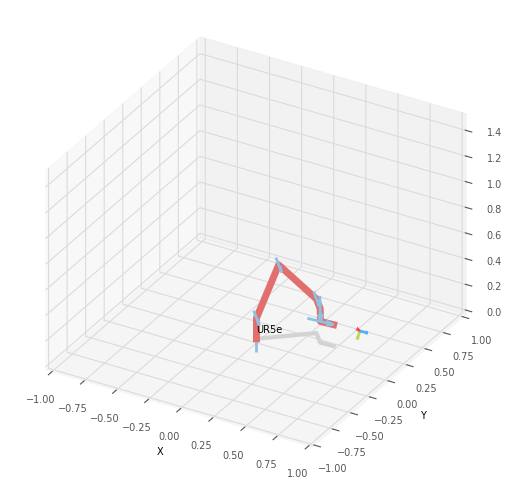

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5e')

<Figure size 640x480 with 0 Axes>

In [5]:
# visualize the robot at Home position
robotDH.plot(joint_position, block=False, limits=[-1, 1, -1, 1, 0, 1.5],vellipse=False)

## Cubic polynomial trajectory planning

In [6]:
dt = 1/100
planning    = Planning(dt)
speed       = 0.05    
acceleration= 0.25  

# Zero initial and final Cartesian velocities
v0_cart = 0.0
v1_cart = 0.0

pos_start = T_current.t
rpy_start = T_current.rpy(unit='rad')
pos_end   = T_end.t
rpy_end   = T_end.rpy(unit='rad')

state_start = np.hstack((pos_start, rpy_start))
state_end   = np.hstack((pos_end,   rpy_end))

# Estimate motion duration
dist, _    = np.linalg.norm(pos_end - pos_start), None
T_total,profile  = planning.compute_traj_time(dist, speed, acceleration)
print("Selected Profile:", profile)
print(f"Total Trajectory Time: {T_total:.3f} seconds")

num_steps = int(np.ceil(T_total / dt)) + 1
t_vec     = np.linspace(0, T_total, num_steps)

# Trajectory arrays (N×6)
pos_traj   = np.zeros((num_steps, 6))
speed_traj = np.zeros((num_steps, 6))
acc_traj   = np.zeros((num_steps, 6))

# —————— only change is here ——————
for axis in range(6):
    t_arr, p_arr, v_arr, a_arr = planning.cubic_trajectory(
        state_start[axis],
        state_end[axis],
        v0_cart,
        v1_cart,
        T_total
    )
    pos_traj[:,   axis] = p_arr.flatten()
    speed_traj[:, axis] = v_arr.flatten()
    acc_traj[:,   axis] = a_arr.flatten()

# ————————————————————————————————

print("Number of points:", len(pos_traj))
print("Start speeds:", speed_traj[0])
print("End   speeds:", speed_traj[-1])

traj_T = []
for p in pos_traj:
    # p[0:3] = x,y,z  and  p[3:6] = roll,pitch,yaw (rad)
    T_i = SE3(p[0], p[1], p[2]) \
          @ SE3.RPY(p[3], p[4], p[5], unit='rad')
    traj_T.append(T_i)

print("Total Waypoints:", len(traj_T))
print("Start pose:", traj_T[0])
print("Goal  pose:", traj_T[-1])

waypoint_goal_tcp = traj_T[-1].t.tolist() + list(traj_T[-1].rpy())
print("Waypoints goal TCP:", waypoint_goal_tcp)

waypoints = []
for T in traj_T:
    waypoints.append(T)


Selected Profile: Trapezoidal
Total Trajectory Time: 13.038 seconds
Number of points: 1305
Start speeds: [0. 0. 0. 0. 0. 0.]
End   speeds: [-1.38777878e-17  2.11758237e-22  0.00000000e+00  6.77626358e-21
  3.38813179e-21  1.69406589e-21]
Total Waypoints: 1305
Start pose:   -0.1235   -0.05836   0.9906    0.7012    
  -0.7633    0.6435   -0.05728   0.1843    
  -0.6341   -0.7632   -0.124     0.1721    
   0         0         0         1         

Goal  pose:   -0.1236   -0.05828   0.9906    0.9035    
  -0.7633    0.6435   -0.05735   0.1843    
  -0.6341   -0.7632   -0.124    -0.4371    
   0         0         0         1         

Waypoints goal TCP: [0.9035034184486379, 0.18425659123476879, -0.4370886739671642, -1.7318443587261685, 0.686842056802218, -1.7312759524010408]


## plotting trajectory

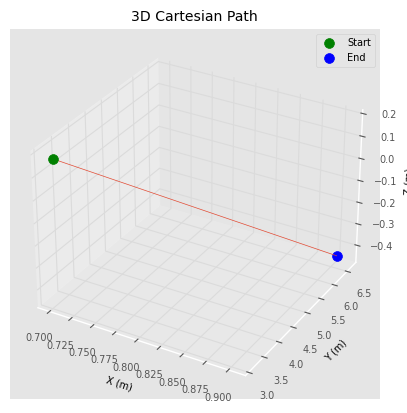

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1) 3D path of the end‑effector
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_start[0], pos_start[1], pos_start[2], color='green', s=50, label="Start")
ax.scatter(pos_end[0], pos_end[1], pos_end[2], color='blue', s=50, label="End")
ax.plot(
    pos_traj[:,0],  # x
    pos_traj[:,1],  # y
    pos_traj[:,2],  # z
)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Cartesian Path')
ax.legend()
plt.show()

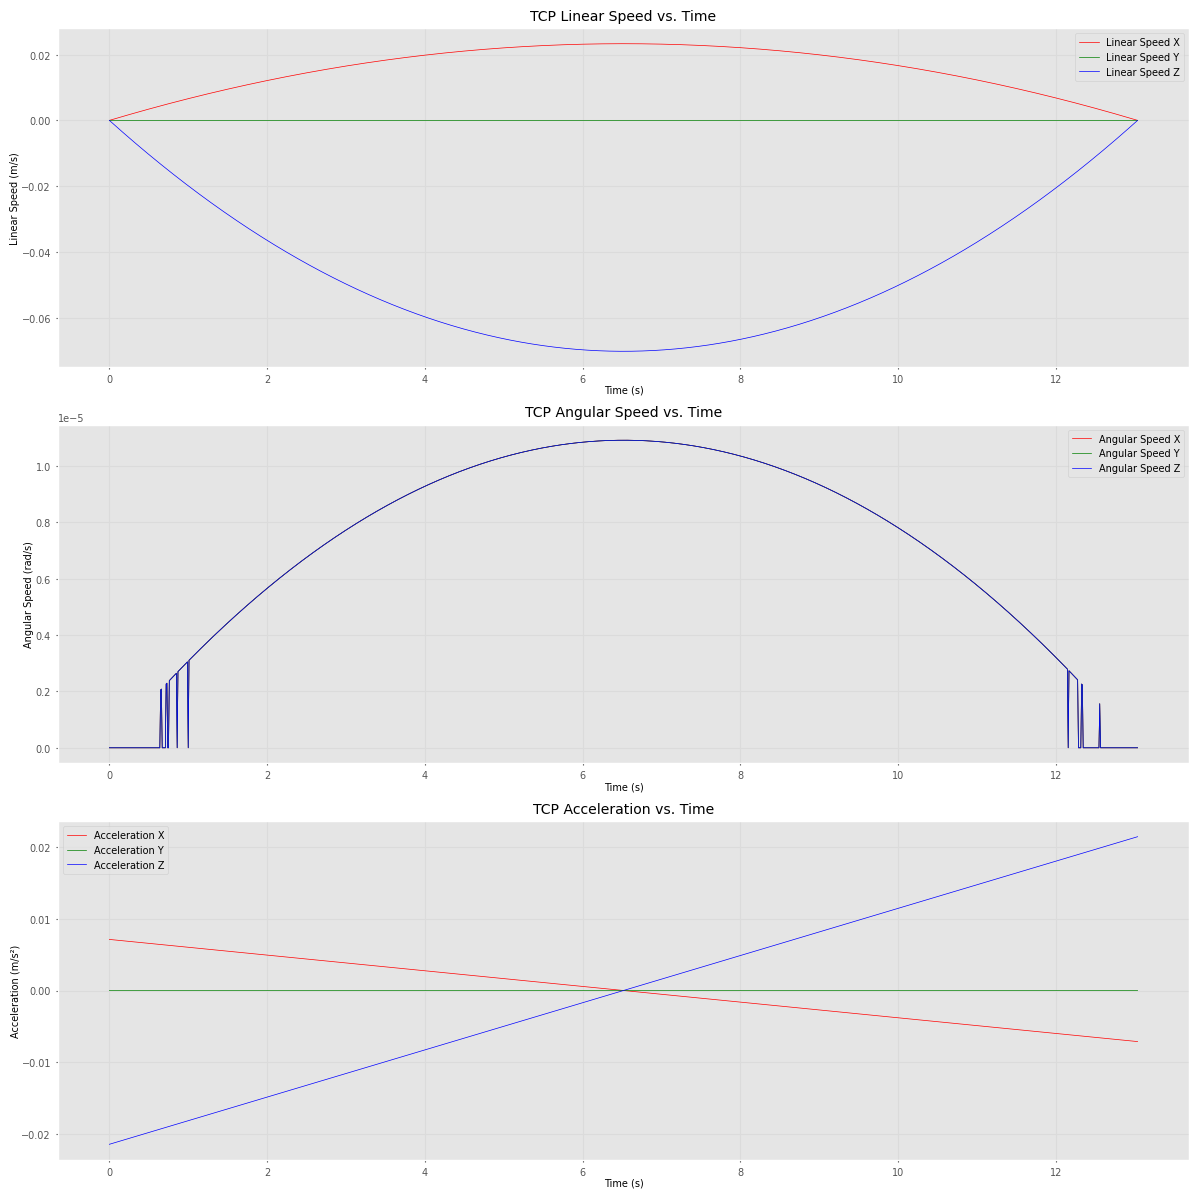

In [8]:
import numpy as np

import matplotlib.pyplot as plt

# Calculate angular speeds from SE3 poses
angular_speeds = np.zeros((len(traj_T), 3))  # Initialize array for angular speeds
for i in range(1, len(traj_T)):
    # Compute the relative transformation between consecutive poses
    delta_T = traj_T[i - 1].inv() * traj_T[i]
    # Extract the angular velocity (rotation vector) from the relative transformation
    angular_speeds[i, :] = delta_T.angvec()[0] / dt  # Divide by dt to get angular speed

# Create a figure with a specified size
plt.figure(figsize=(12, 12))

# Plot linear speeds
plt.subplot(3, 1, 1)
plt.plot(t_arr, speed_traj[:, 0], 'r-', label='Linear Speed X')  # Red dots for X axis speed
plt.plot(t_arr, speed_traj[:, 1], 'g-', label='Linear Speed Y')  # Green dots for Y axis speed
plt.plot(t_arr, speed_traj[:, 2], 'b-', label='Linear Speed Z')  # Blue dots for Z axis speed
plt.xlabel("Time (s)")
plt.ylabel("Linear Speed (m/s)")
plt.title("TCP Linear Speed vs. Time")
plt.legend()
plt.grid(True)

# Plot angular speeds
plt.subplot(3, 1, 2)
plt.plot(t_arr, angular_speeds[:, 0], 'r-', label='Angular Speed X')  # Red line for X axis angular speed
plt.plot(t_arr, angular_speeds[:, 1], 'g-', label='Angular Speed Y')  # Green line for Y axis angular speed
plt.plot(t_arr, angular_speeds[:, 2], 'b-', label='Angular Speed Z')  # Blue line for Z axis angular speed
plt.xlabel("Time (s)")
plt.ylabel("Angular Speed (rad/s)")
plt.title("TCP Angular Speed vs. Time")
plt.legend()
plt.grid(True)

# Plot acceleration
plt.subplot(3, 1, 3)
plt.plot(t_arr, acc_traj[:, 0], 'r-', label='Acceleration X')  # Red line for X axis acceleration
plt.plot(t_arr, acc_traj[:, 1], 'g-', label='Acceleration Y')  # Green line for Y axis acceleration
plt.plot(t_arr, acc_traj[:, 2], 'b-', label='Acceleration Z')  # Blue line for Z axis acceleration
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("TCP Acceleration vs. Time")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

## REAL robot trajectory planning

In [9]:
joint_trajectory = []  
for idx, T_pose in enumerate(traj_T):
    pos = T_pose.t.tolist() 
    orientation = T_pose.rpy() 
    tcp_pose_list = pos + list(orientation)
    q_joint = real_robot.robot_get_ik(tcp_pose_list)
    if q_joint is None:
        print(f"IK failed for waypoint {idx}.")
        break  # or handle the error as needed
    joint_trajectory.append(q_joint)
if len(joint_trajectory) != len(traj_T):
    raise RuntimeError("Incomplete joint trajectory. Please check IK solutions for all waypoints.")

print("Successfully computed joint trajectory for all waypoints.")

Successfully computed joint trajectory for all waypoints.


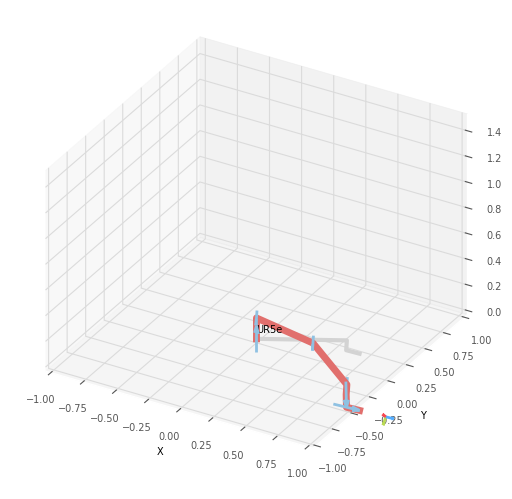

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5e')

<Figure size 640x480 with 0 Axes>

In [10]:
robotDH.plot(joint_trajectory[-1], block=False, limits=[-1, 1, -1, 1, 0, 1.5],vellipse=False)

In [11]:
print("Joint trajectory length:", traj_T[-1].t.tolist()+list(traj_T[-1].rpy()))

Joint trajectory length: [0.9035034184486379, 0.18425659123476879, -0.4370886739671642, -1.7318443587261685, 0.686842056802218, -1.7312759524010408]


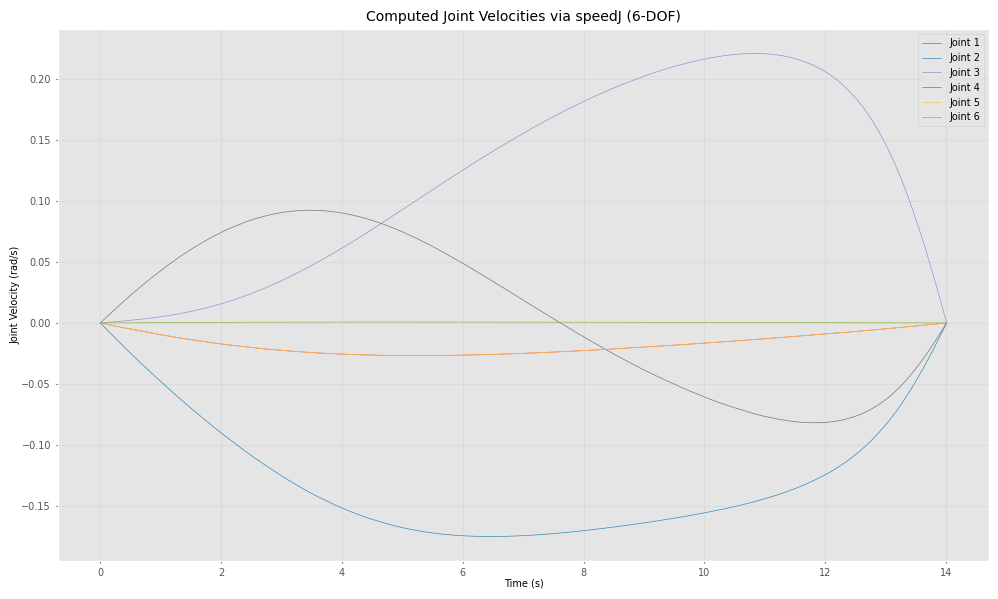

In [12]:
import numpy as np
import time
import matplotlib.pyplot as plt

dt                   = 1/100
joint_acceleration   = 0.25  # rad/s^2

computed_joint_velocities = []
time_stamps              = []
start_time               = time.time()

for i in range(len(traj_T)):
    # 1) Timestamp
    t_cur = time.time() - start_time
    time_stamps.append(t_cur)

    # 2) Feed-forward Cartesian twist (vx,vy,vz,wx,wy,wz)
    v_ff = speed_traj[i]  # shape (6,)

    # 3) No angular feedback here (pure feed-forward)
    twist = v_ff

    # 4) Resolved-rate IK
    q_current = joint_trajectory[i]
    J         = robotDH.jacob0(q_current)
    condJ     = np.linalg.cond(J)
    if condJ > 1e9:
        print(f"Aborting at step {i}: ill-conditioned Jacobian (cond={condJ:.2e})")
        break

    dq = np.linalg.pinv(J, rcond=1e-2) @ twist
    computed_joint_velocities.append(dq)

    # 5) Send speedJ
    real_robot.robot_speed_J(
        dq.tolist(),
        acceleration=joint_acceleration,
        time=dt
    )
    time.sleep(dt)

# Stack into a 2D array (N×6)
if computed_joint_velocities:
    computed_joint_velocities = np.vstack(computed_joint_velocities)
else:
    computed_joint_velocities = np.zeros((0, 6))

# Plotting
plt.figure(figsize=(10, 6))
for j in range(computed_joint_velocities.shape[1]):
    plt.plot(time_stamps,
             computed_joint_velocities[:, j],
             label=f'Joint {j+1}')
plt.xlabel("Time (s)")
plt.ylabel("Joint Velocity (rad/s)")
plt.title("Computed Joint Velocities via speedJ (6-DOF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


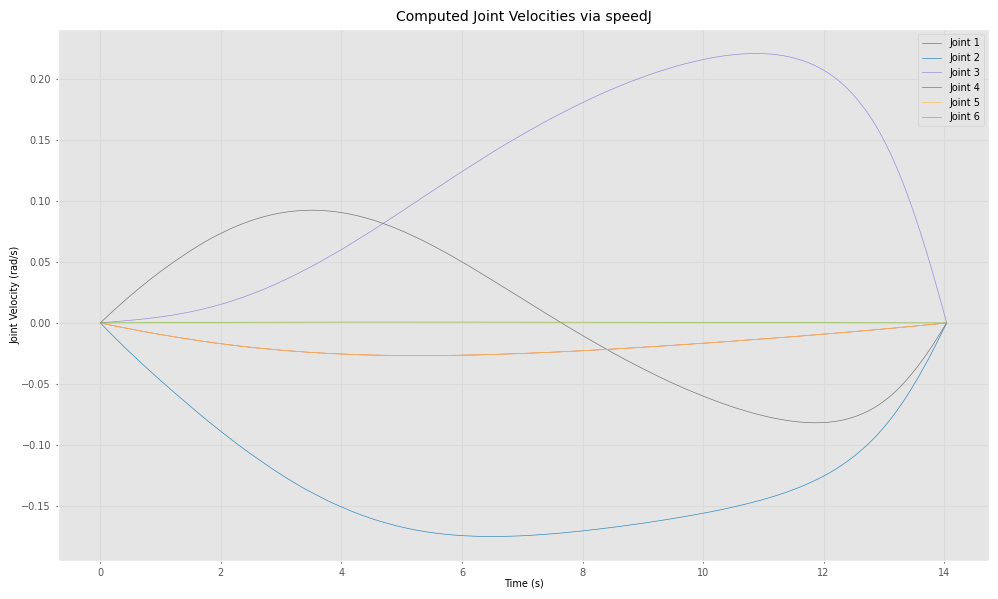

In [26]:
import numpy as np
import time
import matplotlib.pyplot as plt

dt                   = 1/100
joint_acceleration   = 0.25  # rad/s^2

computed_joint_velocities = []
time_stamps              = []
start_time               = time.time()

for i in range(len(traj_T)):
    # 1) Timestamp
    current_time = time.time() - start_time
    time_stamps.append(current_time)

    # 2) Build a 6-vector twist: linear + zero angular
    v_lin = speed_traj[i, :3]                           # (3,)
    twist = np.hstack((v_lin, np.zeros(3)))             # (6,)

    # 3) Get current joint config & Jacobian
    q_current = joint_trajectory[i]
    J         = robotDH.jacob0(q_current)
    condJ     = np.linalg.cond(J)
    if condJ > 1e9:
        print(f"Aborting at step {i}: ill-conditioned Jacobian (cond={condJ:.2e})")
        break

    # 4) Resolved-rate IK: use pseudoinverse, not inv()
    dq = np.linalg.pinv(J, rcond=1e-2) @ twist
    computed_joint_velocities.append(dq)

    # 5) Send speedJ
    real_robot.robot_speed_J(
        dq.tolist(),
        acceleration=joint_acceleration,
        time=dt
    )
    time.sleep(dt)

# stack into a 2D array (N×6); if empty, will be shape (0,6)
if computed_joint_velocities:
    computed_joint_velocities = np.vstack(computed_joint_velocities)
else:
    computed_joint_velocities = np.zeros((0, 6))

# --- Plotting the Computed Joint Velocities ---
plt.figure(figsize=(10, 6))
for j in range(computed_joint_velocities.shape[1]):
    plt.plot(time_stamps,
             computed_joint_velocities[:, j],
             label=f'Joint {j+1}')
plt.xlabel("Time (s)")
plt.ylabel("Joint Velocity (rad/s)")
plt.title("Computed Joint Velocities via speedJ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
real_robot.robot_move_speed_stop()
real_robot.robot_move_home()
real_robot.robot_release()


Moving to home position...
Arrived at home position.
